# Credit Data - Model Selection
## Author: Alex Davis
## Date: 01/29/2024

The purpose of the script is to use the inputs from the feature engineering script to create a useful classification algorithm to predict credit score. This script may include additional feature engineering if needed, but will focus on model selection and parameter tuning.

## Import Packages

In [1]:
#import packages for data manipulation
import pandas as pd

#import packages for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import pycaret.classification as pycr
import pycaret.utils as pycu

#packages for model saving
import pickle 


## Import Data

In [2]:
#import model inputs from feature engineering script
data = pd.read_csv("data/model_inputs.csv")

#display first 5 rows of the data
data.head()

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Changed_Credit_Limit,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Monthly_Inhand_Salary,Avg_Num_of_Delayed_Payment,Num_Credit_Inquiries,Years_of_Credit,Payment_of_Min_Amount_Yes,Credit_Score
0,1911412.0,3,4,3,4,3,11.27,80998.0,26.822620,49.574949,8.041530e+09,3.124941e+09,1824.843333,6.0,4,22,0,Good
1,1911412.0,3,4,3,4,-1,11.27,80998.0,31.944960,49.574949,1.182802e+09,2.846292e+09,1824.843333,6.0,4,22,0,Good
2,1911412.0,3,4,3,4,3,0.00,80998.0,28.609352,49.574949,8.169952e+09,3.312099e+09,1824.843333,6.0,4,22,0,Good
3,1911412.0,3,4,3,4,5,6.27,80998.0,31.377862,49.574949,1.994581e+09,2.234513e+09,1824.843333,6.0,4,22,0,Good
4,1911412.0,3,4,3,4,6,11.27,80998.0,24.797347,49.574949,4.142015e+09,3.414892e+08,1824.843333,6.0,4,22,0,Good


## Model Selction
Here, we will quickly test different classifiers and compute their KPIs. This will not be used to select the final model, but to give us 2-4 models to continue with.

In [7]:
#create a mock train and test set for pycaret
mock_train = data.sample(n=round(len(data) * 0.66), random_state=1066)
mock_test = data.drop(mock_train.index)


In [8]:
#pycaret will fit the data to multiple model and give us KPIs in a table
#these models use the default parameters
mock_models = pycr.setup(data = mock_train, target="Credit_Score", session_id=1066)

,Description,Value
0,Session id,1066
1,Target,Credit_Score
2,Target type,Multiclass
3,Target mapping,"Good: 0, Poor: 1, Standard: 2"
4,Original data shape,"(54374, 18)"
5,Transformed data shape,"(54374, 18)"
6,Transformed train set shape,"(38061, 18)"
7,Transformed test set shape,"(16313, 18)"
8,Numeric features,17
9,Preprocess,True


In [21]:
#fit the mock training data to multiple models and evalutate the output
model_comparison = pycr.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7706,0.8802,0.7706,0.7700,0.7700,0.6172,0.6174,3.3770
et,Extra Trees Classifier,0.7635,0.8715,0.7635,0.7629,0.7628,0.6043,0.6047,1.2800
lightgbm,Light Gradient Boosting Machine,0.7215,0.8477,0.7215,0.7217,0.7206,0.5320,0.5329,2.0180
gbc,Gradient Boosting Classifier,0.6942,0.8247,0.6942,0.6938,0.6910,0.4777,0.4806,10.1440
dt,Decision Tree Classifier,0.6826,0.7296,0.6826,0.6827,0.6826,0.4741,0.4741,0.2330
ada,Ada Boost Classifier,0.6455,0.7082,0.6455,0.6434,0.6361,0.3786,0.3858,0.8680
lda,Linear Discriminant Analysis,0.6133,0.7489,0.6133,0.6074,0.6018,0.3202,0.3272,0.0940
ridge,Ridge Classifier,0.5999,0.0000,0.5999,0.5878,0.5654,0.2597,0.2810,0.0720
svm,SVM - Linear Kernel,0.5316,0.0000,0.5316,0.3387,0.3691,0.0001,0.0018,3.6370
dummy,Dummy Classifier,0.5316,0.5000,0.5316,0.2826,0.3690,0.0000,0.0000,0.0650


## Prepare Train and Test Data
Here, we will prepare our train and test sets that will feed into the model.

In [3]:
#change our dependent variable to a category
data["Credit_Score"] = data["Credit_Score"].astype('category')

In [4]:
# Split the data into features (X) and target (y)
x = data.drop(columns = 'Credit_Score', axis=1)
y = data['Credit_Score']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Model Creation
The test above pointed us towards a few promissing models. Random Forest seem to be the best, with Extra Trees and Light Gradient Boost also as likely canidates. In this section, we will experiement with these models and try to optimize their per.

### Random Forest

#### Default Model

First, we will use the random foreest model with the default parameters and evaluate metrics such as accuracy, precision, and recall.

In [25]:
#initialize random forest classifier with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

#use model to make prediction
y_pred = rf.predict(x_test)


Accuracy: 0.785493600117699
F1 Score: 0.7852032688220573


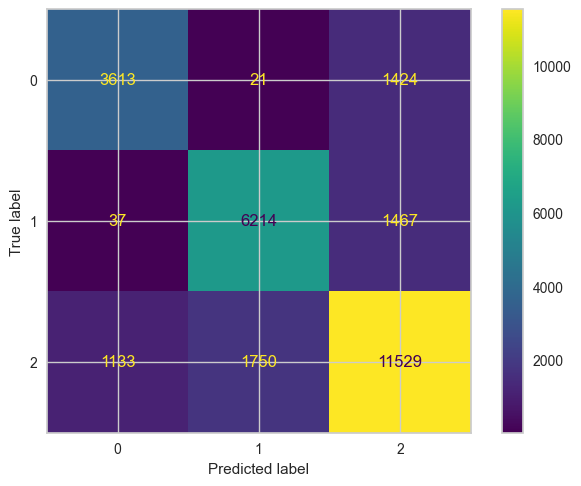

In [8]:
#funtion to return the model's metrics
def model_metrics():
    
    accuracy = accuracy_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred, average = "weighted")
    matrix = confusion_matrix(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f_score)

    ConfusionMatrixDisplay(confusion_matrix = matrix).plot();

#call function to display accuracy, f1score, and confusion maxtrix
model_metrics()

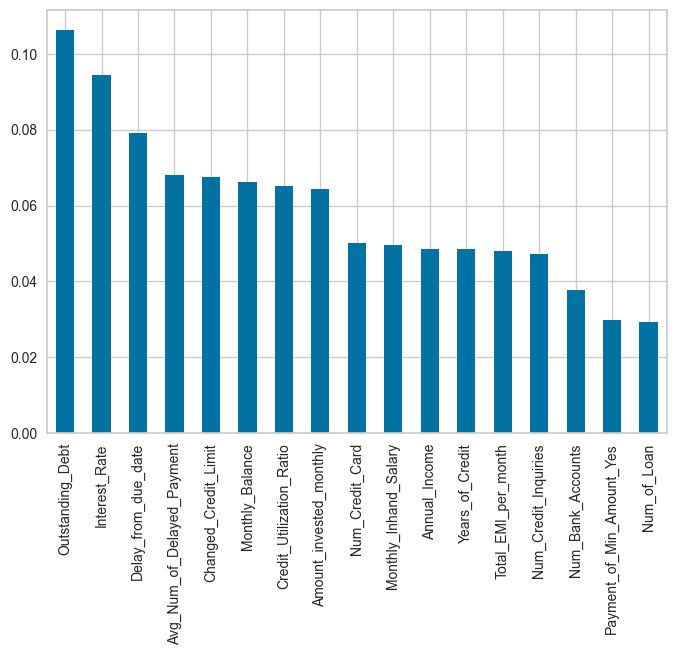

In [18]:
#create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index = x_train.columns).sort_values(ascending=False)

#plot a bar chart of feature importance
feature_importances.plot.bar();

This model appears to be promising. All features are of relativley equal importance, accuracy is at 78%, and the F1 Score is 0.78 (meaning precision and recall are somewhat balanced). 

#### Hyperparameter Tuning

Now, let's see if we can optimize our hyperparmeters to boost our accuracy and f1 score.

In [12]:
#create a grid of parameters for the model to fit to and find the best fit
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [13]:
#use grid search to find the optimal set of parameters
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 

grid_search.fit(x_train, y_train)

#print the best set of parameters
print(grid_search.best_estimator_) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [19]:
#create random forest model with optimal parameters
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

#fit the model to the training data
rf.fit(x_train, y_train)

#use model to make prediction
y_pred = rf.predict(x_test)

Accuracy: 0.6490363395615713
F1 Score: 0.6163438346852714


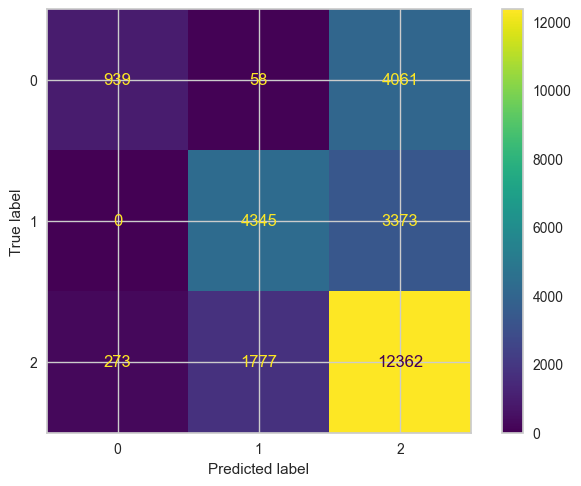

In [20]:
#review metrics
model_metrics()

The new hyperparameters made the model worse. It is over predicting 'standard'. Further experimentation with the parameters are unlikely to improve the model.

#### Dimensionality Reduction
Next, we will try dimensionality reduction with principal component analysis. This is unlikely to improve the model, but could help in the chance that there is too much noise in the model and data.

In [35]:
#create scaler object
sc = StandardScaler()

#apply scaler to training and test set
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [41]:
#create PCA object, starting with 4 dimensions
pca = PCA(n_components = 4)

In [37]:
#apply PCA function to train and test set
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [38]:
#print explained variance
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.23641149 0.06407809 0.05967603 0.05925048]


In [39]:
#initialize random forest classifier with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

#use model to make prediction
y_pred = rf.predict(x_test)

Accuracy: 0.595005149330587
F1 Score: 0.5901322385601773


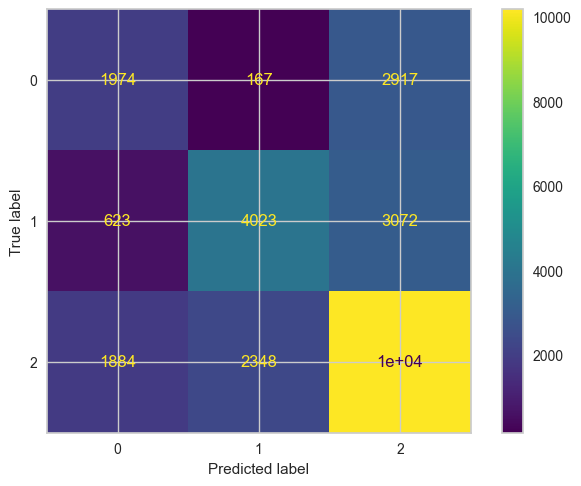

In [40]:
#review metrics
model_metrics()

Look like dimensionality reduction was not the right approach. Accuracy dropped significantly and our dimensions we created through principal component analysis only capture a small amount of the variance of the dependent variables.

## Final Model
Below is our final model, which is a default random forest model. This is probably due to the many different factors and considerations when is comes to the credit score. Keeping that in mind, the accuracy of about 80% is fairly impressive. Also, considering this model is well balanced, we can learn from this model, such as the most important factors of someone credit score.

In [5]:
# Split the data into features (X) and target (y)
x = data.drop(columns = 'Credit_Score', axis=1)
y = data['Credit_Score']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [6]:
#initialize random forest classifier with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

#use model to make prediction
y_pred = rf.predict(x_test)

Accuracy: 0.785493600117699
F1 Score: 0.7852032688220573


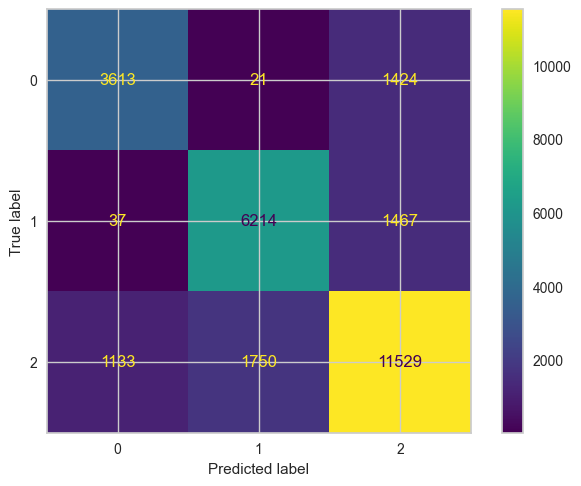

In [9]:
#review metrics
model_metrics()

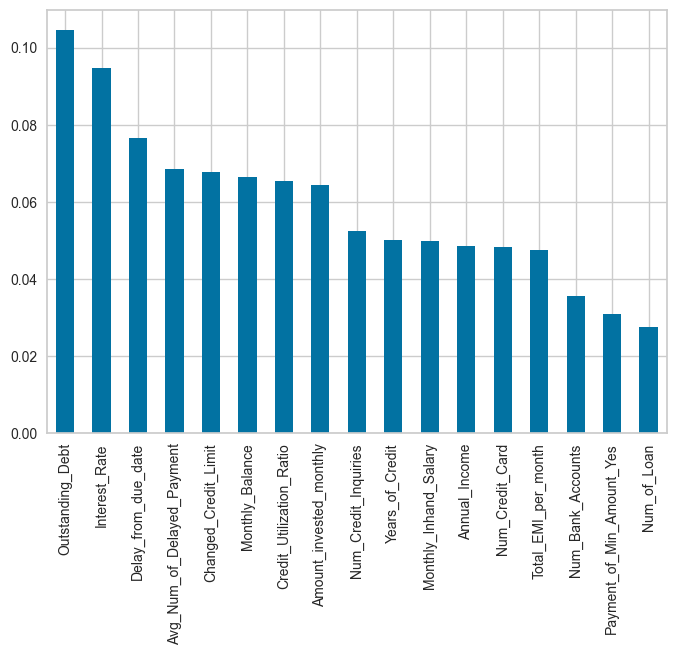

In [10]:
#create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index = x_train.columns).sort_values(ascending=False)

#plot a bar chart of feature importance
feature_importances.plot.bar();

In [13]:
#save model as a pickle file
filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))